In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 42.3 MB/s eta 0:00:00


In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
df = pd.read_excel('1400.xlsx')

In [6]:
df['SI'] = df['CC50-MDCK, mmg/ml']/df['IC50, mmg/ml']
df['S_leng'] = df['SMILES'].str.len ()

In [7]:
df.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44


In [ ]:
df.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures,S_leng
count,1468.000000,1468.000000,1.468000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000,1468.000000
mean,50.277063,186.491530,2.210854e+04,384.739636,3.831744,1.333787,81.273215,364.909216,62.997956
std,92.184768,1009.454293,4.771268e+05,153.164268,2.860473,1.803663,54.078778,210.154325,32.373175
min,0.000010,0.031928,3.616134e-02,110.157000,0.000000,0.000000,0.000000,1.000000,13.000000
25%,2.500000,30.375000,1.833333e+00,283.049250,2.000000,0.000000,39.440000,183.500000,46.000000
50%,10.100000,90.400000,5.528073e+00,349.371000,3.000000,1.000000,71.840000,365.000000,55.000000
75%,49.450000,300.000000,2.778741e+01,446.508000,5.000000,2.000000,106.160000,546.500000,68.000000
max,1000.000000,37646.000000,1.632222e+07,1159.380000,19.000000,11.000000,319.510000,728.000000,279.000000


In [ ]:
df['Title'].size

1408

In [8]:
df = df[df.SI <= 100]

In [9]:
df = df[df['IC50, mmg/ml'] < 250]
df = df[df['CC50-MDCK, mmg/ml'] < 250]
df = df[df.S_leng < 120]
df = df[df.SI <= 100]

In [10]:
df = df[df.S_leng < 140]
df = df[df['IC50, mmg/ml'] < 310]

In [11]:
df.columns

Index(['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'SMILES',
       'Pictures', 'S_leng'],
      dtype='object')

In [12]:
df_w = df[[ 'IC50, mmg/ml', 'SMILES']]

In [112]:
df_w.shape

(826, 3)

In [13]:
df_w.describe()

,"IC50, mmg/ml"
count,826.000000
mean,21.085836
std,29.285577
min,0.004219
25%,2.700000
50%,8.200000
75%,30.000000
max,200.000000


## Анализ данных

<Axes: xlabel='S_leng', ylabel='Count'>

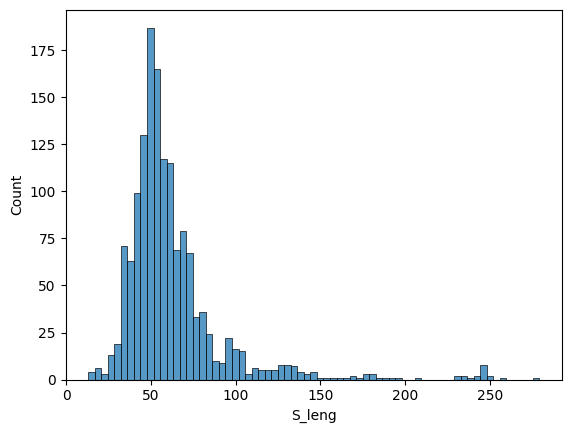

In [ ]:
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50, mmg/ml', ylabel='Count'>

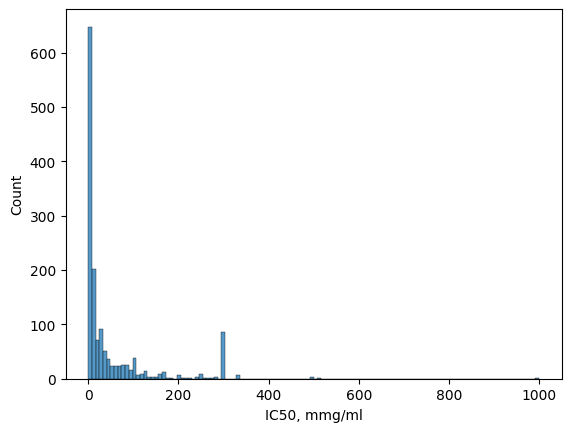

In [ ]:
sns.histplot(df['IC50, mmg/ml'])

In [14]:
df[df['IC50, mmg/ml'] < 250]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44
13,1018-As-105,13.5,73.0,5.407407,641.133,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,63.0,102
14,1019-YA-214,50.0,41.5,0.830000,472.674,6,0,77.32,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,64.0,82
15,1031-ОЛ7-144-1,6.4,53.0,8.281250,431.406,8,2,123.02,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,65.0,68
...,...,...,...,...,...,...,...,...,...,...,...
1409,CHEMBL5176004,199.1,199.1,1.000000,220.274,4,0,55.99,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,NaN,39
1415,CHEMBL4294644,150.2,150.2,1.000000,154.254,1,1,20.23,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,NaN,34
1429,CHEMBL154,3.7,230.3,62.243243,230.266,1,0,46.53,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,NaN,37
1448,CHEMBL3040734,29.1,176.3,6.058419,139.243,0,0,26.02,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,NaN,37


In [15]:
df_v = df[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng']]

In [16]:
df_v = df_v[df_v.SI < 500]
df_v = df_v[df_v.S_leng < 140]

In [17]:
df_v.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,21.085836,62.008071,12.309207,360.474478,3.426150,1.157385,73.337324,55.915254
std,29.285577,56.648737,19.131256,108.146808,2.267022,1.388935,44.082755,16.143000
min,0.004219,0.031928,0.036161,139.243000,0.000000,0.000000,0.000000,16.000000
25%,2.700000,16.900000,1.663584,284.291750,2.000000,0.000000,38.770000,46.000000
50%,8.200000,43.350000,4.241162,345.306000,3.000000,1.000000,67.130000,53.000000
75%,30.000000,93.375000,13.098810,418.469250,4.000000,2.000000,99.330000,63.000000
max,200.000000,243.000000,100.000000,811.002000,14.000000,8.000000,270.280000,119.000000


In [18]:
sns.boxplot(df['Polar SA'])

KeyError: ignored

In [19]:
df_v.groupby('Hydrogen bond acceptors')['IC50, mmg/ml'].mean()

Hydrogen bond acceptors
0     11.600000
1     16.532906
2     20.490741
3     31.696894
4     21.559379
5     23.335304
6     14.037736
7      8.443087
8     16.074994
9     28.323778
10    11.583333
11    13.900000
12     4.350000
13     7.500000
14     1.700000
Name: IC50, mmg/ml, dtype: float64

In [20]:
df_v.groupby('Hydrogen bond donors')['IC50, mmg/ml'].mean()

Hydrogen bond donors
0    14.400772
1    29.043460
2    31.258481
3    15.385965
4     4.574572
5     4.916305
6     8.428571
7    17.633333
8     2.700000
Name: IC50, mmg/ml, dtype: float64

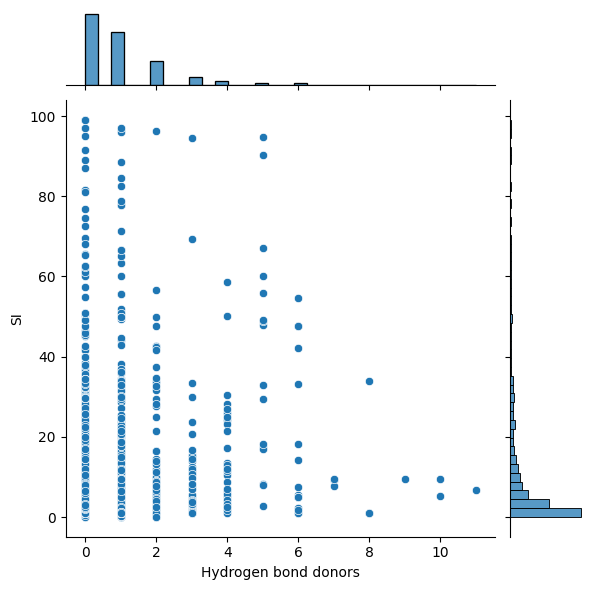

In [ ]:
sns.jointplot(x='Hydrogen bond donors', y='SI', data=df_v);

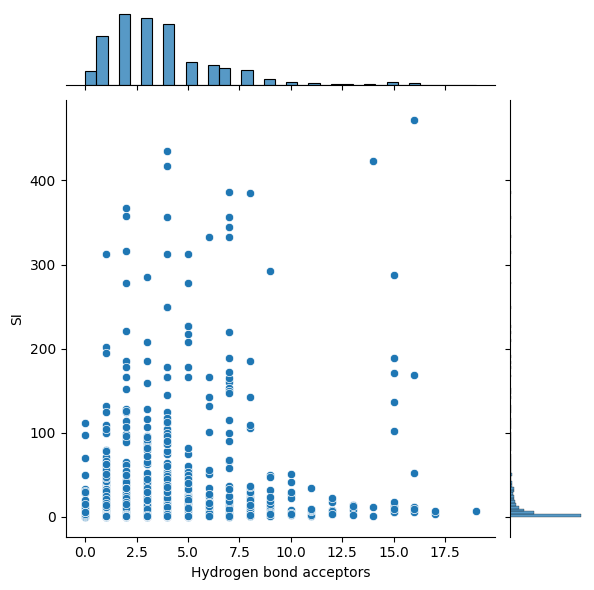

In [ ]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

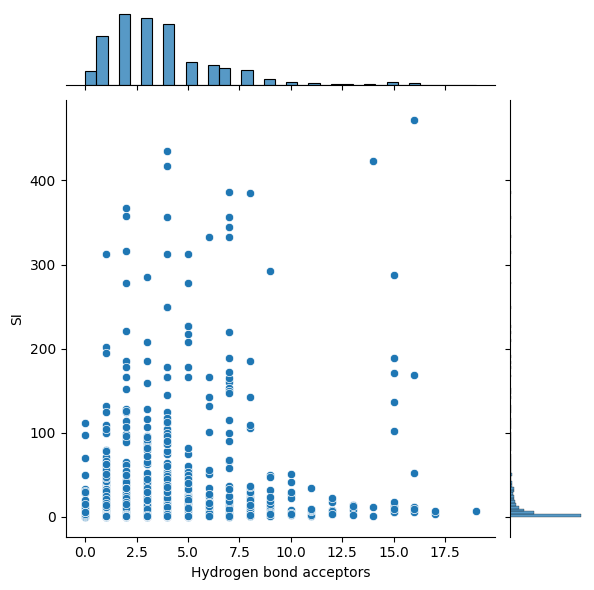

In [ ]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

In [ ]:
df_v.corr()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
"IC50, mmg/ml",1.000000,0.041928,-0.027915,-0.079176,-0.038622,-0.123526,-0.070082,-0.074757
"CC50-MDCK, mmg/ml",0.041928,1.000000,0.022510,-0.009572,-0.023458,0.004398,0.010386,-0.001949
SI,-0.027915,0.022510,1.000000,-0.003564,0.018826,0.025557,0.063151,-0.000465
Molecular weight,-0.079176,-0.009572,-0.003564,1.000000,0.599001,0.311860,0.663605,0.832344
Hydrogen bond acceptors,-0.038622,-0.023458,0.018826,0.599001,1.000000,0.506830,0.767056,0.495037
Hydrogen bond donors,-0.123526,0.004398,0.025557,0.311860,0.506830,1.000000,0.671514,0.378091
Polar SA,-0.070082,0.010386,0.063151,0.663605,0.767056,0.671514,1.000000,0.576099
S_leng,-0.074757,-0.001949,-0.000465,0.832344,0.495037,0.378091,0.576099,1.000000


## Векторайзер

In [ ]:
OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2

In [21]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7b9b61a9edc0>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x7b9b61a9ec00>
13,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,<rdkit.Chem.rdchem.Mol object at 0x7b9b61a9f300>
14,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a5c3c0>
15,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a5c430>
...,...,...
1409,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a86c00>
1415,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a86c70>
1429,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a86ce0>
1448,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,<rdkit.Chem.rdchem.Mol object at 0x7b9b60a86d50>


In [22]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-pelnfwdz
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-pelnfwdz
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11357 sha256=f1e1e2f538a8d267ec31c30a1a41fe0b8e5500ae049168d74bdd9f75c77ce74c
  Stored in directory: /tmp/pip-ephem-wheel-cache-74oej37n/wheels/1c/de/14/fd9892b48271e63e56b00c7015c754ae6189e258fa313a7c63
Successfully built molvecgen


In [23]:
from molvecgen.vectorizers import SmilesVectorizer

In [113]:
df_w.shape

(826, 3)

In [114]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True,)
smivec.fit(df_w.Molecule.values, )

In [115]:
print(smivec.charset)
smivec.dims

)Fr6c2Ii51Hl-e/oSB\4C]@nP3=[(s#+NO^$?


(116, 37)

In [ ]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 136


In [26]:
y = df_w['IC50, mmg/ml'].values.reshape((-1,1))
X = df_w.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [ ]:
y_train

In [ ]:
from pprint import pprint

In [ ]:
y_train.shape

(844, 1)

In [ ]:
y_test.shape

(352, 1)

In [ ]:
y_validation.shape

(212, 1)

In [27]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [28]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[78]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.72683604]))

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([124, 116, 37])

In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [96]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedChemicalPredictor(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_features=128, dropout_rate=0.3):
        super(EnhancedChemicalPredictor, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_dim, num_features)
        # self.embedding = nn.Linear(37, 64)
        self.bn1 = nn.BatchNorm1d(116)

        # MultiheadAttention layer
        self.attention = nn.MultiheadAttention(embed_dim=num_features, num_heads=num_heads)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(num_features, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.embedding(x))
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = x.permute(0, 2, 1)

        attn_output, _ = self.attention(x, x, x)
        x = self.dropout1(attn_output.permute(1, 0, 2).mean(dim=1))

        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        return self.fc3(x)


epochs = 400
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.4 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.005  # The initial learning rate for the optimizer

In [101]:
import torch.nn as nn

class ChemNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ChemNet, self).__init__()

        self.input_layer = nn.Linear(37, 64)

        self.bn1 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(dropout_rate)

        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1)

        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)

        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        # Применяем входной слой
        x = self.input_layer(x)

        # Нормализация
        x = x.permute(0, 2, 1)  # изменение порядка измерений для BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)  # возвращаем порядок измерений обратно

        # Механизм внимания
        x, _ = self.attention(x, x, x)

        # Применяем промежуточные слои
        x = self.dropout(x)  # Применяем dropout после механизма внимания
        x = nn.ReLU()(self.fc1(x.mean(dim=1)))

        x = self.dropout(x)  # Применяем dropout после первого полносвязного слоя
        x = nn.ReLU()(self.fc2(x))

        # Применяем выходной слой
        x = self.output_layer(x)

        return x


In [89]:
epochs = 100
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 116   # The mini_batch size during training
learning_rate = 0.01  # The initial learning rate for the optimizer

In [32]:
dims

(116, 37)

In [102]:
# model = EnhancedChemicalPredictor(dims[1], 1, 128, dropout_rate)
model = ChemNet(0.3)
model.cuda()

ChemNet(
  (input_layer): Linear(in_features=37, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [99]:
X_validation_t[10:12].shape

torch.Size([2, 116, 37])

In [103]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[-0.0850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [104]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [105]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [106]:
for smiles, labels in train_loader:
    print(smiles)
    print(labels)
    break

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [107]:
train_loader.batch_size

116

In [108]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = torch.tensor(smiles, device=device).float()
        #print(smiles)
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        print(labels.shape)
        print(output.shape)
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([31, 1])
torch.Size([31, 1])


<ipython-input-108-7a7e9cdf6440>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
<ipython-input-108-7a7e9cdf6440>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()


torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([31, 1])
torch.Size([31, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([31, 1])
torch.Size([31, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([31, 1])
torch.Size([31, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([31, 1])
torch.Size([31, 1])
Epoch 5, Training loss: 0.98 Validation loss: 0.92
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([116, 1])
torch.Size([

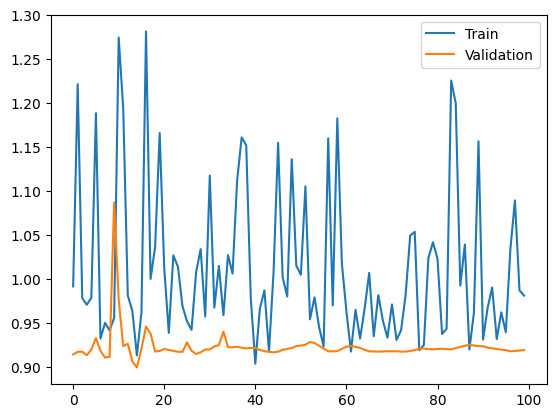

In [109]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [ ]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)


In [ ]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.9020845293998718

In [ ]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

In [ ]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.826	Test RMSE: 0.765


In [ ]:
y_pred_train.shape

torch.Size([1, 684, 1])

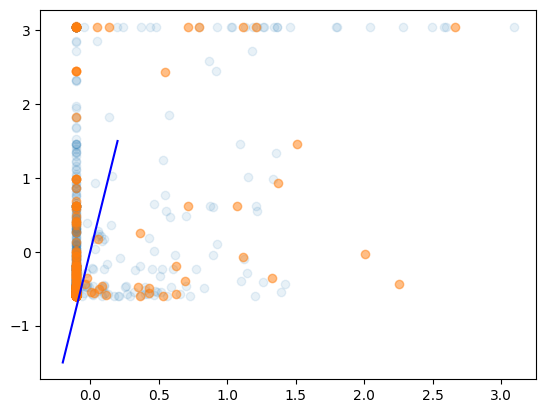

In [ ]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")
#plt.xlim(-1,  1)
#plt.ylim(-0.1,  1)